In [37]:
import matplotlib.pyplot as plt
import numpy as np
import myML
import os
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [38]:
def RGBtohue(RGB):
    R, G, B = RGB
    if R>=G and G>=B: temp = (G-B)/(R-B)
    elif G>=R and R>=B: temp = 2-(R-B)/(G-B)
    elif G>=B and B>=R: temp = 2+(B-R)/(G-R)
    elif B>=G and G>=R: temp = 4-(G-R)/(B-R)
    elif B>=R and R>=G: temp = 4+(R-G)/(B-G)
    elif R>=B and B>=G: temp = 6-(B-G)/(R-G)
    return temp*60

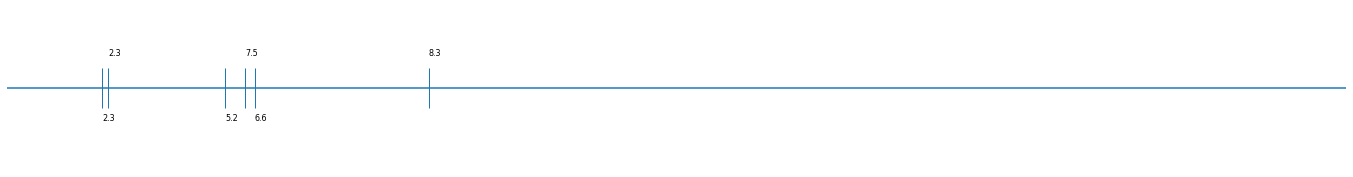

In [39]:
# Load training images. Each image shouldn't have unwanted pixels (surroundings) and must be named with the known pH value
location = os.getcwd()+'\\training\\'
rg = np.empty((2,len(os.listdir(location))))
Y_train = np.empty((1,len(os.listdir(location))))
X_train = np.empty((1,len(os.listdir(location))))

for count, file in enumerate(os.listdir(location)):
    RGB = [np.mean(x) for x in np.array(Image.open(location+file)).T]
    X_train[0,count] = RGBtohue(RGB)+20
    if X_train[0,count]>360: X_train[0,count]-=360
    Y_train[0,count] = float(file.split('.jpg')[0])

#Sort by ascending ph
order = np.argsort(X_train)[0]
X_train = X_train[:,order]
Y_train = Y_train[:,order]


plt.hlines(1,0,360)  # Draw a horizontal line
plt.xlim(0,360)
plt.ylim(0.5,1.5)

y = np.ones(np.shape(X_train[0,:]))   # Make all y values the same
plt.plot(X_train[0,:],y,'|',ms = 40)  # Plot a line at each location specified
for count in range(X_train.shape[1]):
    if count % 2: pos = 1.2
    else: pos = 0.8
    plt.annotate(round(Y_train[0,count],1), [X_train[0,count], pos], fontsize=8)
plt.axis('off')
plt.rcParams['figure.figsize'] = (24, 3)
plt.show()

#Normalization
Xnorm, Ynorm = myML.norm0to1_minmax([1,1],[0,0]), myML.norm0to1_minmax([14],[0])
#X_train, Y_train = Xnorm.normalize(X_train), Ynorm.normalize(Y_train)
Y_train = Ynorm.normalize(Y_train)

In [40]:
Ynorm.recover(Y_train)

array([[2.3 , 2.31, 5.2 , 7.5 , 6.6 , 8.3 ]])

In [9]:
#Cross-validation using the training samples to find the elbow of the curve (to avoid under or overfitting)
epochs = 500        #Times that the entire dataset is used to train the NN
lr = 2            #Learning rate
lambd = 0           #Regularization term
activation = ['ReLU','sigmoid']
lossname = 'MSE'
optimizer = 'GD'

n = 14
yplot_train = np.zeros(n)
times = 10
for i in range(1,n+1):
    nodes = [X_train.shape[0], i, Y_train.shape[0]]
    #print('Trying with '+str(i)+' nodes in the hidden layer')
    aux_train = 500
    for j in range(times):
        np.random.seed(None)
        neuralnetwork = myML.ANN(nodes, activation, lossname)
        costs = neuralnetwork.train(X_train, Y_train, epochs, optimizer, lr, lambd)
        if costs[epochs-1]<aux_train: aux_train = costs[epochs-1]

    yplot_train[i-1] = aux_train

plt.plot(range(1,n+1),yplot_train,label='Training set error')
plt.xlabel('Nº of neurons in hidden layer')
plt.ylabel('Cost function error')
plt.legend(loc='best')
plt.show()

KeyboardInterrupt: 

[[ 1.    1.1   1.11  2.    2.1   2.11  2.3   2.31  2.32  3.    3.01  3.02
   4.    4.01  4.02  5.    5.01  5.02  5.2   6.    6.01  6.02  6.6   7.
   7.01  7.02  7.9   8.    8.01  8.02  8.3   9.    9.01  9.02 10.   10.01
  10.02 11.   11.01 12.   12.01 12.02 13.   13.01 13.98 13.99 14.  ]]
[[ 2.4675001   2.28738046  2.17716771  2.33307849  2.12566216  2.12612401
   2.2472703   2.14255828  2.1227639   3.13101374  2.20557874  2.26780287
   5.14754034  2.52419646  3.01622583  5.96853447  4.62810856  6.55274569
   5.69817218  6.13425919  5.70397886  6.95438093  6.21431999  6.81274797
   6.23915265  7.81954833  6.04413737  7.81686434  8.17100264  8.20210351
   8.2202783   8.61684809  8.09746847  8.82862443  9.1302144  12.41629315
  11.69594896 12.49824342 11.85244986 12.25746615 12.03923477 12.42566125
  12.45008555 11.78042399 12.37768439 12.39518807 12.46858748]]


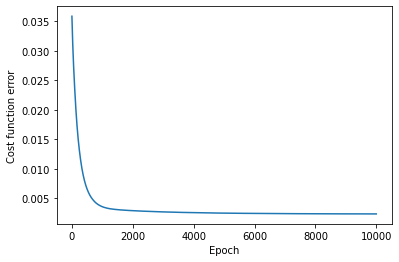

0.0023393879689518012

In [53]:
#Train a model for future use
nodes = [X_train.shape[0], 6, Y_train.shape[0]]
activation = ['ReLU','sigmoid']
loss = 'MSE'
epochs = 10000

model = myML.ANN(nodes, activation, loss)
costs = model.train(X_train, Y_train, epochs, 'GD', lr=0.1, lambd=0, printepochs=False)

print(Ynorm.recover(Y_train))
print(Ynorm.recover(model.test(X_train)))

plt.plot(range(epochs),costs)
plt.xlabel('Epoch')
plt.ylabel('Cost function error')
plt.show()
costs[-1]

In [64]:
# Load training images. Each image shouldn't have unwanted pixels (surroundings) and must be named with the known pH value
location = os.getcwd()+'\\test\\'
X = np.empty((2,1))

for count, file in enumerate(os.listdir(location)):
    RGB = [np.mean(x) for x in np.array(Image.open(location+file)).T]
    X[:,0] = RGB[0]/(RGB[0]+RGB[1]+RGB[2]), RGB[1]/(RGB[0]+RGB[1]+RGB[2])
    print(file.split('.jpg')[0])
    X = Xnorm.normalize(X)

    Y = model.test(X)
    print(round(Ynorm.recover(Y)[0,0],3))

0vinegar8
7.886
1vinegar8
5.555
2fontvella_sacalm
12.414
3tapwaterhidro
11.858
4bottle7
11.684
5bottle4,93
11.774
6bottle4
11.38
